# Latent Space Manipulations & Visulizations - Autoencoder & Variational Autoencoder

* Autoencoder (AE) and Variational Autoencoder (VAE) models compared through the perspective of the latent vectors they generate after training on Fashion MNIST dataset
  * Both models use the same 3-layer CNN encoder & decoder  
&nbsp;
* Class interpolation, random latents, and general latent space arithmetic explored with decoder reconstructions back to image space

* Class groupings & variance of AE vs. VAE latent vectors explored with direct & indirect visulization of latents 

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.manifold import TSNE
from models import AE, VAE
from utils import *

<Figure size 2000x500 with 0 Axes>

### Download dataset
* MNIST dataset can also be used without modification

In [ ]:
# get data
dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:13<00:00, 1990600.70it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 171645.30it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:04<00:00, 943276.45it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17413126.61it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



### Set Hyperparameters & Instantiate Models

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.0015
latent_dim = 24
num_epochs = 8
kld_loss_weight = 0.001

model_vae = VAE(latent_dim=latent_dim, kld_weight=kld_loss_weight).to(device)
optimizer_vae = torch.optim.Adam(model_vae.parameters(), lr=lr)

model_ae = AE(latent_dim=latent_dim).to(device)
optimizer_ae = torch.optim.Adam(model_ae.parameters(), lr=lr)

### Train Models

In [ ]:
# Train the VAE
for epoch in range(num_epochs):
  for batch_idx, (x, y) in enumerate(iter(dataloader)):
    x, y = x.to(device), y.to(device)
    z, x_recon, mu, log_var = model_vae(x)
    optimizer_vae.zero_grad()
    recon_loss, kld = model_vae.get_loss(x, x_recon, mu, log_var)
    loss = recon_loss + model_vae.kld_loss_weight * kld
    optimizer_vae.zero_grad()
    loss.backward()
    optimizer_vae.step()
  print(f'Epoch: {epoch + 1} | Reconstruction Loss: {recon_loss:.4f} | KLD: {kld:.4f}')

Epoch: 0 | Loss: 0.0245
Epoch: 1 | Loss: 0.0236
Epoch: 2 | Loss: 0.0226
Epoch: 3 | Loss: 0.0238
Epoch: 4 | Loss: 0.0211
Epoch: 5 | Loss: 0.0226
Epoch: 6 | Loss: 0.0206
Epoch: 7 | Loss: 0.0207


In [ ]:
# train the AE
for epoch in range(num_epochs):
  for batch_idx, (x, y) in enumerate(iter(dataloader)):
    x, y = x.to(device), y.to(device)
    z, x_recon = model_ae(x)
    optimizer_ae.zero_grad()
    loss = model_ae.get_loss(x, x_recon)
    optimizer_ae.zero_grad()
    loss.backward()
    optimizer_ae.step()
  print(f'Epoch: {epoch + 1} | Reconstruction Loss: {loss:.4f}')

Epoch: 0 | Loss: 0.0057
Epoch: 1 | Loss: 0.0071
Epoch: 2 | Loss: 0.0087
Epoch: 3 | Loss: 0.0098
Epoch: 4 | Loss: 0.0060
Epoch: 5 | Loss: 0.0075
Epoch: 6 | Loss: 0.0085
Epoch: 7 | Loss: 0.0077


### Sample & display X values and their reconstructions
- Both models will reconstruct Fashion MNIST items well with 24 latents (about a 32:1 compression ratio from the 784 pixels in image space)
- VAE reconstructions will be a little blurry becuase it samples from a distribution of z values rather than a point, and its latents are regularized to a normal distribution
- AE reconstructions are clearer becuase they are decoded directly from the input image

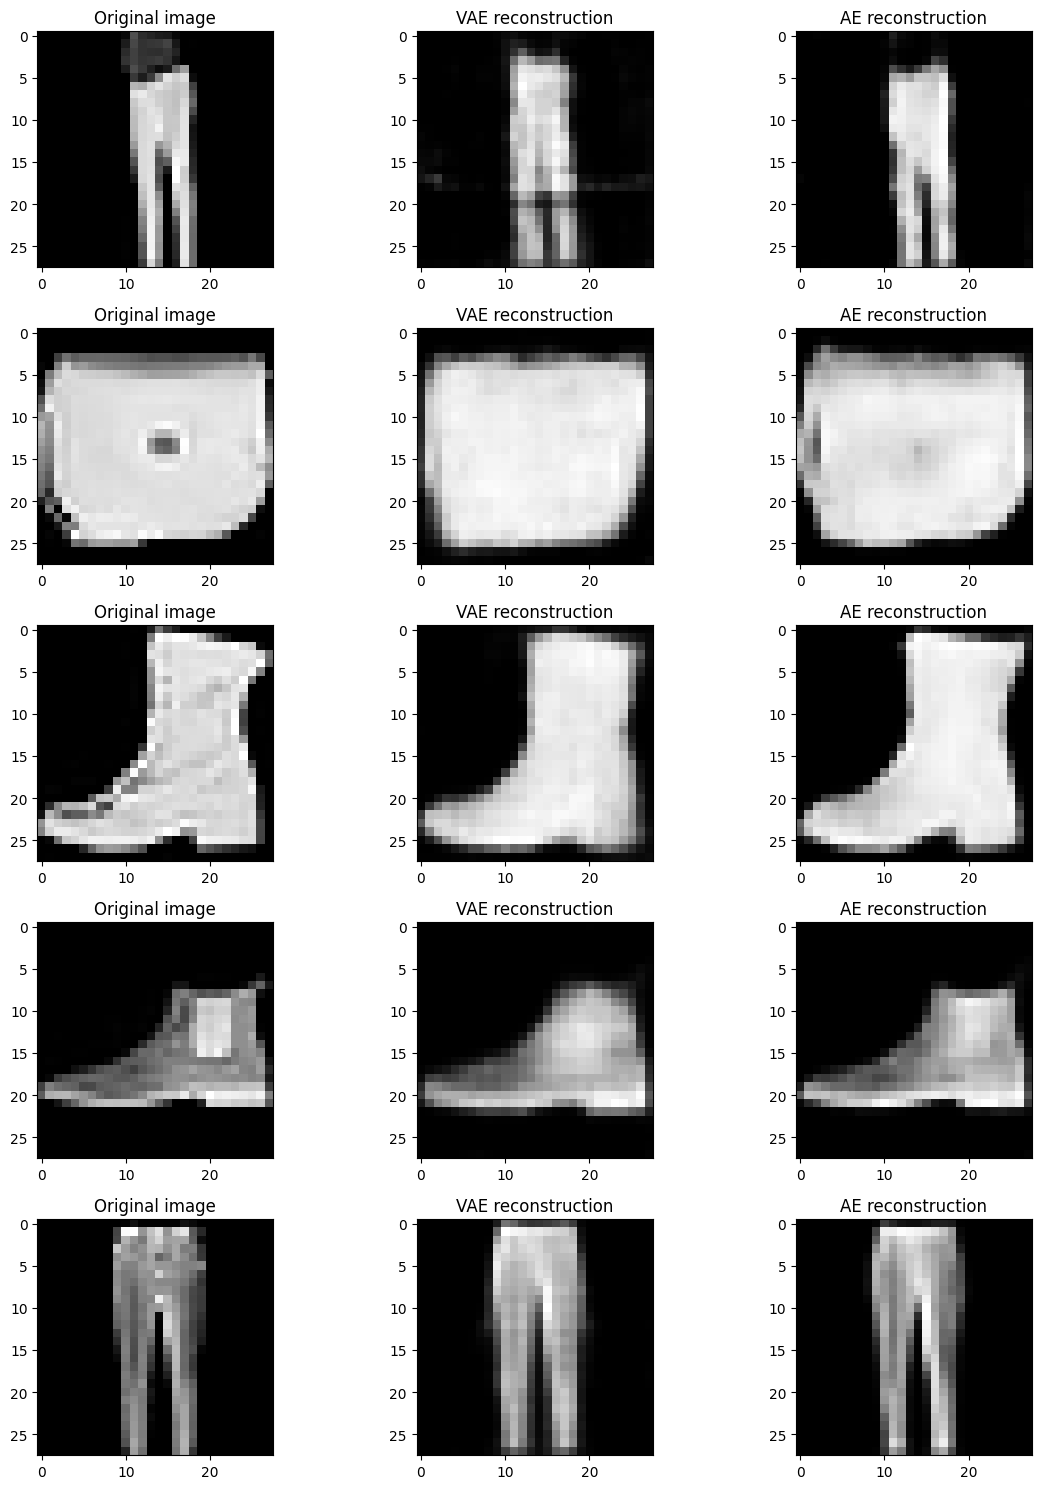

In [ ]:
display_reconstructed_x(dataloader, model_vae, model_ae)

# Latent Space Analysis

### Latent Space Summary: TSNE plots of latent vectors by class label

- TSNE compacts the models' high-dimensional latent space into 2-dimensional space that's easy to visualize.
- The below graphs plot the TSNE representations of latent vectors generated for hundreds of examples
- Both models exhibit semantically meaningful latent spaces, ie class groupings are visible
- The VAE's latent space shows little empty space between classes, meaning that the regulated probability distribution sampling style of the VAE has ensured that a greater proportion of latent space carries semantic meaning than the vanilla AE, which has large white gaps in latent space.  

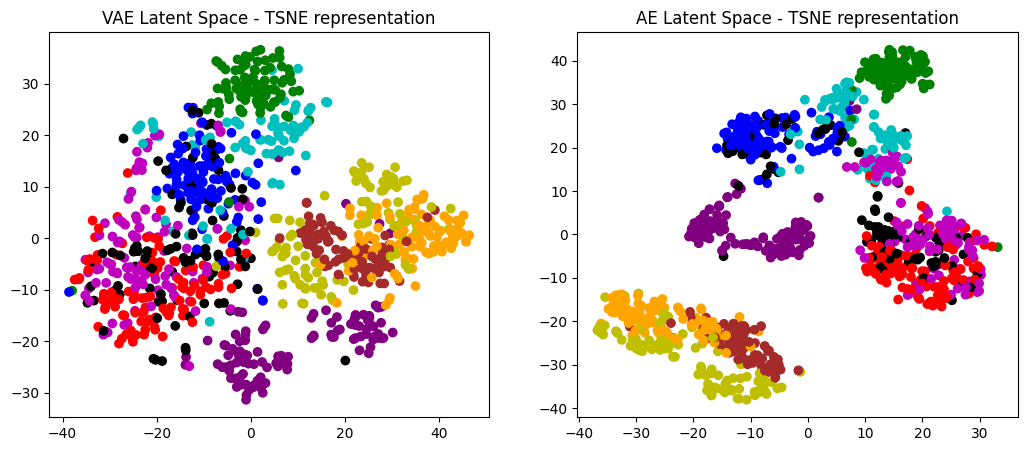

In [ ]:
plot_latent_space_summary(model_vae, model_ae, dataloader)

### Latent Space Deep Dive: Actual latent vectors, plotted 2 dimensions at a time

- The below plots visualize the latent space vectors, 2 dimensions at a time, with the VAE latent space on the left, and the AE latent space on the right.
This shows that the VAE successfully regulates each dimension of the latent vector close to N(0, 1).

- The latent space plots make it easy to see why a VAE is typically far better at generating random examples than a vanilla AE:
- In the VAE latent space, the random latent vector (red dot) is surrounded very closely by encoded latent vectors from real data (blue dots).
- In AE latent space, the random latent vector is typically not close to many encoded examples of real data
- Models don't learn to assign meaning to latent vectors that don't have close counterparts in training. This leads to unexpected behavior (ie poor reconstruction quality) when the decoder reconstructs a random latent back to image space.

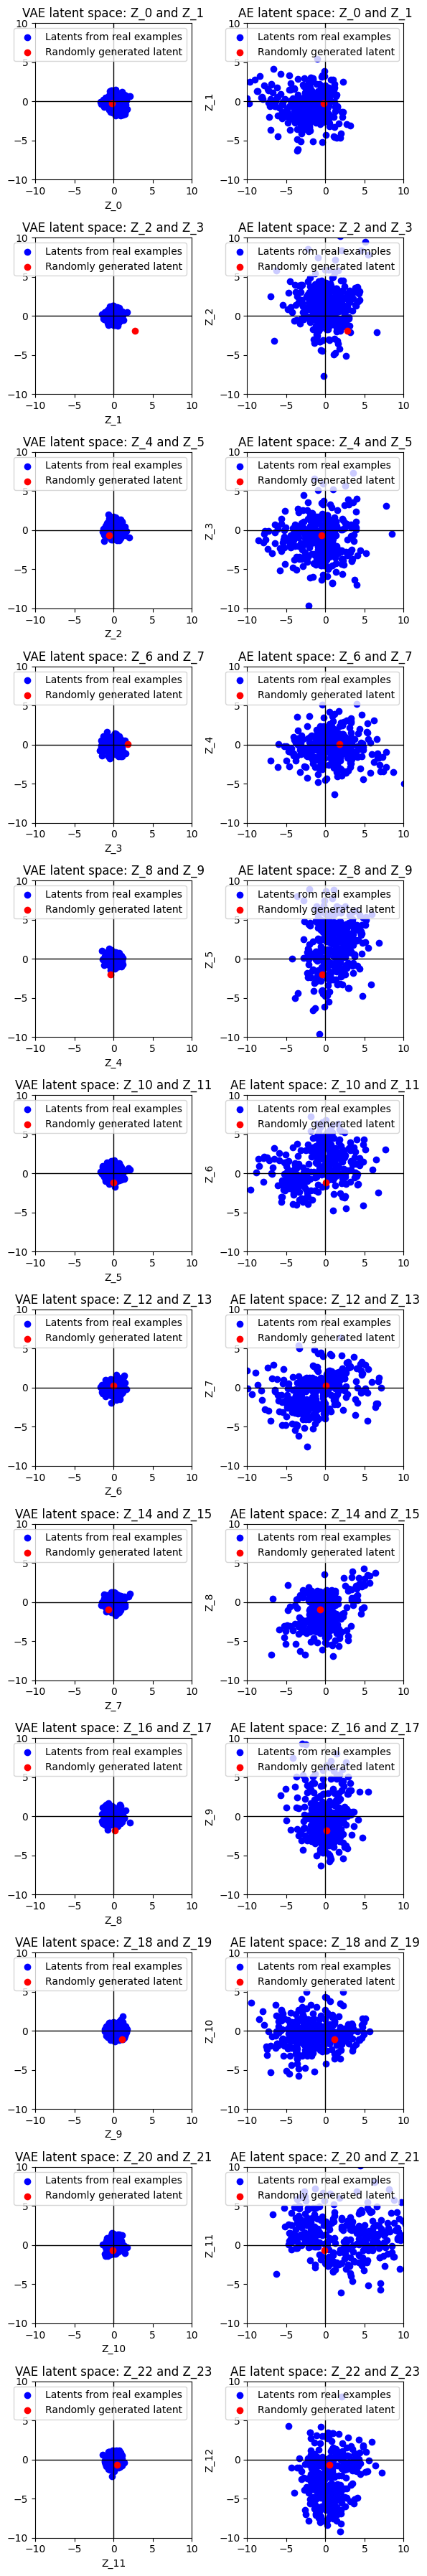

In [ ]:
random_z = torch.randn(model_vae.latent_dim).to(device)
compare_latent_spaces_exact(model_vae, model_ae, dataloader, random_z)

## Sampling From Latent Space: VAE vs AE
- "Input Latent" (reconstructed in the top row) is the latent visualized as the red points above
- VAE reconstructions from random latents tend to make sense - they are recognizable, or some feasible combination of dataset items 
  - A VAE's latent space is probabilistic and regularized, making it adept at decoding latent vectors it hasn't seen in training
- AE reconstructions from random latents typically don't make sense since its latent space is not regularized 
  - An AE's latent space is deterministic and unregularized, resulting in poor decodings of latent vectors outside of the training set


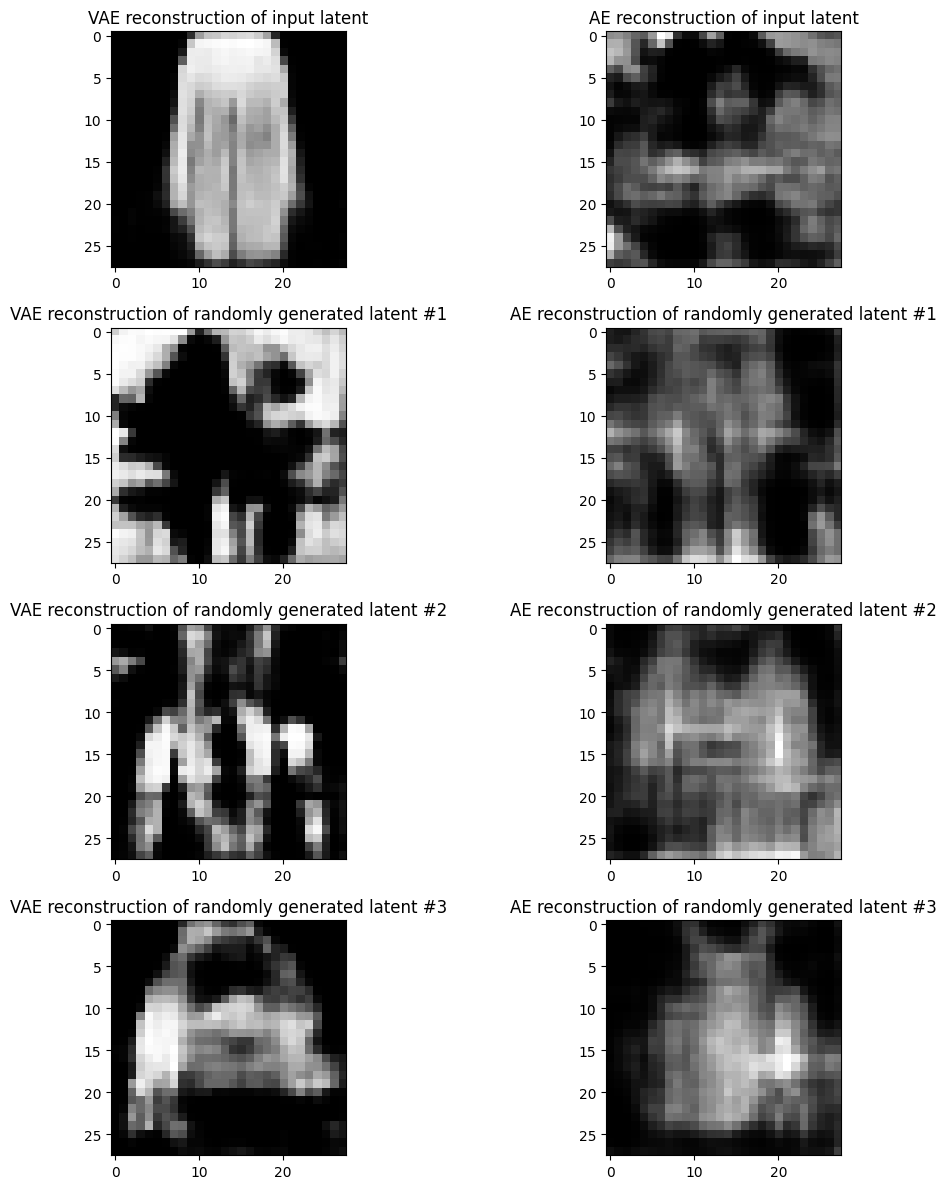

In [ ]:
show_random_samples(model_vae, model_ae, random_z)

## Manipulating Latent Space Vectors
- Often, adding to or subtracting from one dimension of a latent vector uncovers what that dimension encodes
  - This can also be done with a list of multiple dimensions 
- This effect is typically easier to see in a VAE than an AE. 
  - The regularizer on the VAE's latent vectors encourages a smoother and therefore more meaningful latent space than the AE 

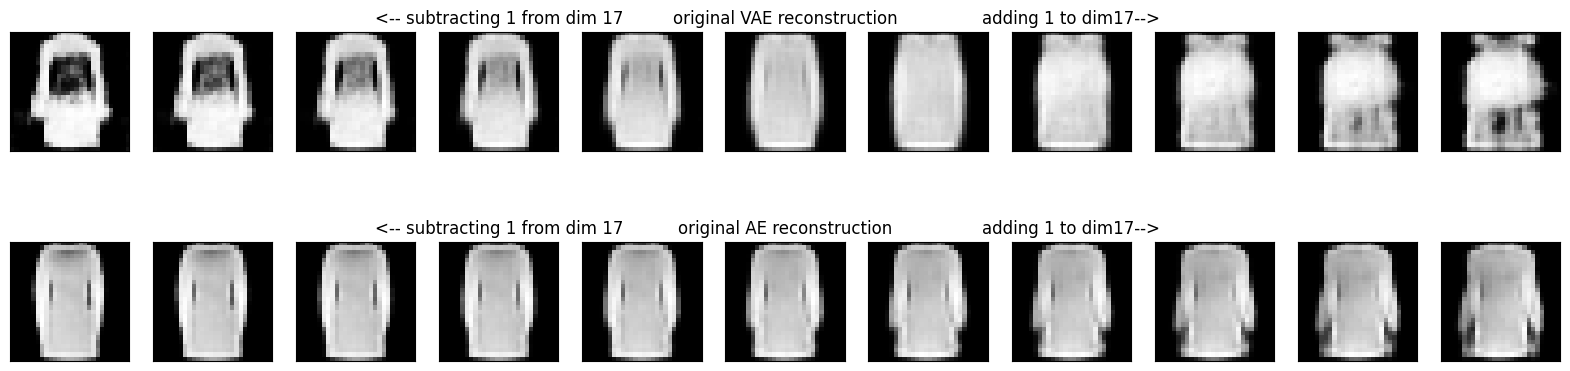

In [ ]:
# Starting latent vector is an encoding of a real image of chosen class
chosen_class = 3
dim_to_change = 17 # this can also be a list, try changing multiple dimensions

x, y = get_x_y_num_batches(dataloader, device, num_batches=1)
x_in = get_x_by_label(chosen_class, x, y).to(device).unsqueeze(dim=0)

start_z_vae, _ = model_vae.encode(x_in)
start_z_ae = model_ae.encode(x_in)

traverse_latent_space(start_z_vae.flatten(), start_z_ae.flatten(), model_vae, model_ae, dimension_to_change=dim_to_change, rate_of_change=1)

## Latent Space Arithmetic

- Latent vectors tend to be closely bound to features observed in image space
- Subtracting two latent vectors yields the difference between them, which is often interpretable when decoded back into image space.
- In this example, the average latent vectors for two classes are calculated, and then decoded back to image space.
- The differences between these average latent vectors, when decoded back to image space, often match the differences seen in image space

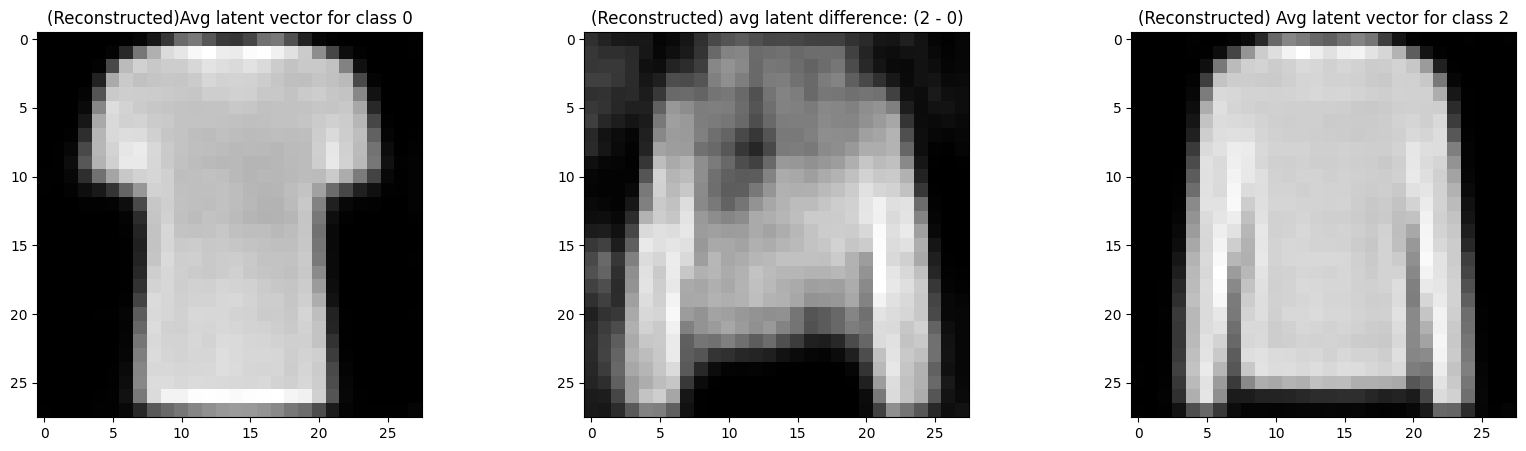

In [ ]:
x, y = get_x_y_num_batches(dataloader, device, 10)
models_list = [model_vae, model_ae]
class1 = 0
class2 = 2

z_vae_class1 = get_average_z(class1, y, x, model_vae)
z_vae_class2 = get_average_z(class2, y, x, model_vae)
z_vae_class_diff = z_vae_class2 - z_vae_class1

figb, axsb = plt.subplots(1, 3)
axsb[0].imshow(model_vae.decoder(z_vae_class1).cpu().squeeze().detach().numpy())
axsb[0].set_title(f'(Reconstructed)Avg latent vector for class {class1}')
axsb[1].set_title(f'(Reconstructed) avg latent difference: ({class2} - {class1})')
axsb[0].set_xticks([])
axsb[1].set_xticks([])
axsb[2].set_xticks([])
axsb[0].set_yticks([])
axsb[1].set_yticks([])
axsb[2].set_yticks([])
axsb[1].imshow(model_vae.decoder(z_vae_class_diff).cpu().squeeze().detach().numpy())
axsb[2].imshow(model_vae.decoder(z_vae_class2 ).cpu().squeeze().detach().numpy())
axsb[2].set_title(f'(Reconstructed) Avg latent vector for class {class2}')

plt.show()

### Latent space arithmetic for class interpolation
- Adding the latent difference (avg_class2_latent - avg_class_1_latent) to an encoded latent vector belonging to class 1 can transform it to class 2 in image space
  - The 'arithmetic' is as follows: new_latent = class_1_latent - avg_class_1_latent + avg_class_2_latent
  - Essentially, it takes the class 1 features out of the latent and replaces them with class 2 features
- In the below images, a gradually larger ratio of the difference vector is added from left to right, demonstrated with reconstructions back to image space

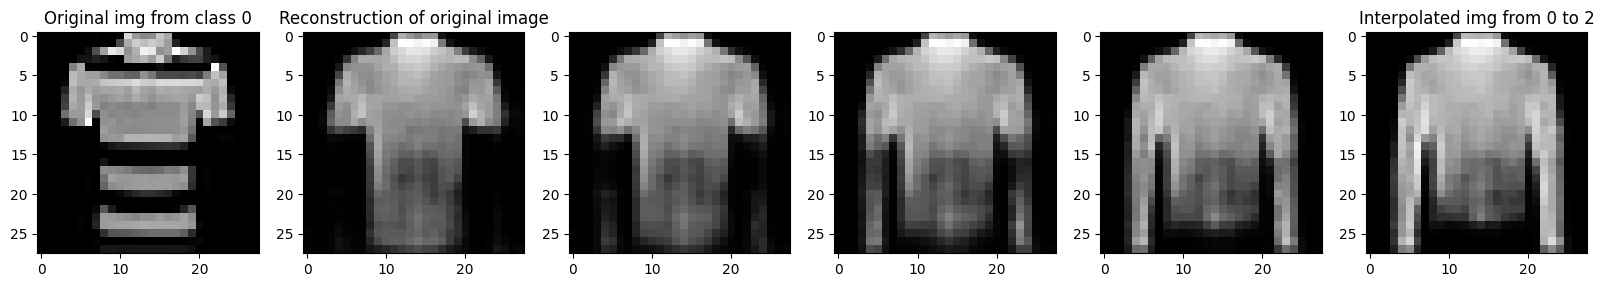

In [ ]:
# VAE
interpolate_btwn_classes(class1, class2, x, y, model_vae)

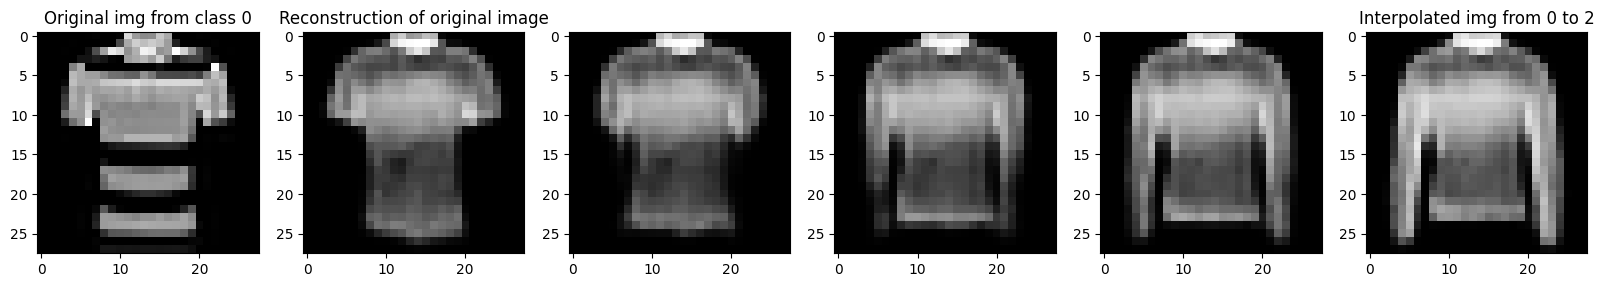

In [ ]:
# AE
interpolate_btwn_classes(class1, class2, x, y, model_ae)